## Importing info and making a DF

In [2]:
import pandas as pd
import numpy as np

orders = pd.read_csv('Orders.csv')

## Getting to know the data

In [3]:
print(orders.columns)
print(orders.describe())

Index(['Row.ID', 'Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode',
       'Customer.ID', 'Customer.Name', 'Segment', 'Postal.Code', 'City',
       'State', 'Country', 'Region', 'Market', 'Product.ID', 'Category',
       'Sub.Category', 'Product.Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping.Cost', 'Order.Priority'],
      dtype='object')
            Row.ID   Postal.Code      Quantity      Discount  Shipping.Cost
count  51290.00000   9994.000000  51290.000000  51290.000000   51290.000000
mean   25645.50000  55190.379428      3.476545      0.142908      26.478567
std    14806.29199  32063.693350      2.278766      0.212280      57.251373
min        1.00000   1040.000000      1.000000      0.000000       1.002000
25%    12823.25000           NaN      2.000000      0.000000       2.610000
50%    25645.50000           NaN      3.000000      0.000000       7.790000
75%    38467.75000           NaN      5.000000      0.200000      24.450000
max    51290.00000  99301.0000

C:\Users\Stephen\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


In [ ]:
orders.head()
orders.isnull()

In [ ]:
orders.dtypes

## Cleaning the Data

In [6]:
orders.Profit = orders.Profit.str.replace('$','').str.replace(',','').astype(float)

In [7]:
#making date-time and creating new columns for month and year

orders['Order.Date'] = pd.to_datetime(orders['Order.Date'])
orders["order_month"] = orders["Order.Date"].apply (lambda x : x.month)
orders.order_month = orders.order_month.astype(int)

orders["order_year"] = orders["Order.Date"].apply(lambda x : x.year)
orders.order_year = orders.order_year

## Figuring out seasonal trends

In [8]:
season_orders = orders.groupby('order_month')['Quantity'].agg(['min', 'max', 'mean', 'sum', 'median'])

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')

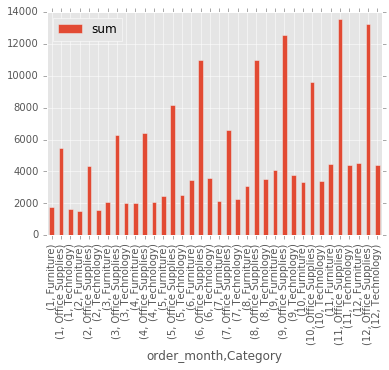

In [10]:
season_cat = orders.groupby(['order_month','Category'])['Quantity'].agg(['sum'])
plt.figure(figsize=(16,6))
season_cat.plot.bar()

## Comb orders and returns

In [11]:
returns = pd.read_csv('Returns.csv')

In [12]:
returns.head()

,Returned,Order ID,Region
0,Yes,CA-2012-SA20830140-41210,Central US
1,Yes,IN-2012-PB19210127-41259,Eastern Asia
2,Yes,CA-2012-SC20095140-41174,Central US
3,Yes,IN-2015-JH158207-42140,Oceania
4,Yes,IN-2014-LC168857-41747,Oceania


## Figuring out what profit we lost

In [13]:
print(orders.shape)
print(returns.shape)

(51290, 26)
(1079, 3)


In [14]:
comb_df = orders.merge(returns, left_on='Order.ID', right_on='Order ID')

In [15]:
comb_df['Order ID'].nunique()

1079

In [19]:
comb_df.columns

Index(['Row.ID', 'Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode',
       'Customer.ID', 'Customer.Name', 'Segment', 'Postal.Code', 'City',
       'State', 'Country', 'Region_x', 'Market', 'Product.ID', 'Category',
       'Sub.Category', 'Product.Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping.Cost', 'Order.Priority', 'order_month',
       'order_year', 'Returned', 'Order ID', 'Region_y'],
      dtype='object')

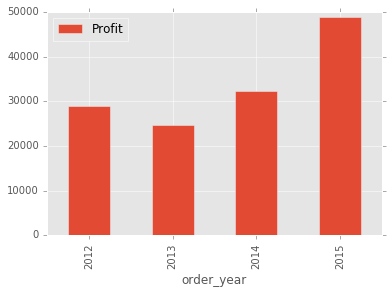

In [36]:
profit_df = comb_df.copy()

profit_df[['Profit']] = profit_df[['Profit']].abs()
year_loss = profit_df.groupby(['order_year'])[['Profit']].sum()
year_loss.plot.bar()

## Figuring number of returns per customer

In [37]:
profit_df.head(20)

In [61]:
return_freq = comb_df[['Customer.ID','Returned']].groupby('Customer.ID').count().reset_index()

return_freq[return_freq.Returned > 1]

print(sum(return_freq.Returned > 1))

print(sum(return_freq.Returned > 4))

547
80


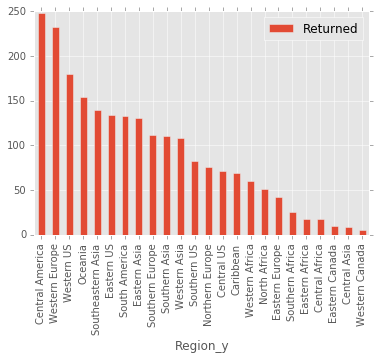

In [80]:
comb_df.groupby('Region_y')[['Returned']].count().sort_values('Returned',ascending = False).plot.bar()

## Identifying which Sub categories are more likely to be returned

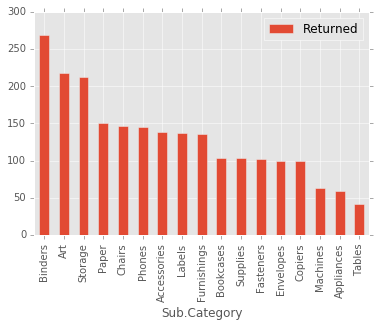

In [143]:
comb_df.groupby('Sub.Category')[['Returned']].count().sort_values('Returned',ascending = False).plot.bar()

# Part II (Machine Learning)

## Making Yes/No returned Feature

In [144]:
test = pd.merge(returns,orders, left_on='Order ID',right_on='Order.ID', how='outer')
test = test.drop(['Region_x','Order.ID', 'Row.ID'], axis=1)
test[['Returned']] = test[['Returned']].fillna('No')

In [145]:
test = test.rename(columns={'Region_y': 'Region'})

test['Ship.Date'] = pd.to_datetime(test['Ship.Date'])
test['Process.Time'] = test['Ship.Date'].sub(test['Order.Date'],axis=0)



In [146]:
test['Process.Time'] = test['Process.Time'].astype('timedelta64[D]')

In [150]:
item_freq = test[['Order ID','Returned']].groupby('Order ID').count().reset_index()

In [154]:
test = test.merge(item_freq,how='outer',on='Order ID')

In [157]:
test = test.rename(columns = {'Returned_x': 'Returned','Returned_y':'Return_Freq' })

In [158]:
test

,Returned,Order ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,...,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,order_month,order_year,Process.Time,Return_Freq
0,Yes,CA-2012-SA20830140-41210,2012-10-28,2012-10-30,First Class,SA-208301402,Sue Ann Reed,Consumer,60610.0,Chicago,...,"$2,735.95",6,0.20,341.99,752.510,High,10,2012,2.0,1.0
1,Yes,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,...,"$1,715.16",2,0.00,720.36,725.570,Critical,12,2012,3.0,8.0
2,Yes,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,...,"$2,197.50",5,0.00,153.75,627.270,Critical,12,2012,3.0,8.0
3,Yes,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,...,"$1,356.03",3,0.00,311.85,458.970,Critical,12,2012,3.0,8.0
4,Yes,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,...,$882.15,5,0.00,114.60,203.920,Critical,12,2012,3.0,8.0
5,Yes,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,...,$148.32,3,0.00,68.22,25.480,Critical,12,2012,3.0,8.0
6,Yes,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,...,$45.45,3,0.00,14.04,17.730,Critical,12,2012,3.0,8.0
7,Yes,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,...,$95.04,2,0.00,13.26,12.590,Critical,12,2012,3.0,8.0
8,Yes,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,...,$23.70,2,0.00,9.48,5.090,Critical,12,2012,3.0,8.0
9,Yes,CA-2012-SC20095140-41174,2012-09-22,2012-09-27,Standard Class,SC-200951402,Sanjit Chand,Consumer,55407.0,Minneapolis,...,"$9,449.95",5,0.00,4630.48,655.610,Medium,9,2012,5.0,4.0
